In [2]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh

import module.geometry.metric as metric
import module.geometry.christoffel as christoffel
import module.misc.tree_util as tree_util

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
key = jax.random.PRNGKey(0)

## Hamiltonian

$$
H = - J \sum_{<i,j>} \bigl[S_i^{(x)} S_j^{(x)} + S_i^{(y)} S_j^{(y)} +S_i^{(z)} S_j^{(z)}\bigr]
$$

In [8]:
# Define a grid
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes, total_sz=0)

# This creates an empty operator (or zero) to which you can add others.
J = 1.
hamiltonian = nk.operator.LocalOperator(hi)

# interactions
for (i,j) in g.edges():
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmax(hi, i) @ nk.operator.spin.sigmax(hi, j)
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmay(hi, i) @ nk.operator.spin.sigmay(hi, j)
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)


hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
all_states = jnp.array([state for state in hi.states()])

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


In [10]:
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1, which = "SA")
E_f = e_gs[0]
psi_gs = psi_gs.reshape(-1)
print("E_f = ", E_f)

E_f =  -32.00000000000016


In [11]:
def calc_H_loc(orbital, parameters, samples):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(samples)
    
    logpsi_sigma = orbital.calc_logpsi(parameters, samples)
    logpsi_eta = orbital.calc_logpsi(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

## Construct Neural Network

In [12]:
def act(x):
    return netket.nn.activation.log_cosh(x)

In [13]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16, name="dense1", param_dtype="float64", kernel_init=jax.nn.initializers.normal(stddev=0.01))(x)
        x = act(x)
        x = jnp.sum(x, axis = -1)

        return jnp.squeeze(x)

## Construct Ansatz

In [14]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (g.n_nodes,))

        self.nn = NN()
        self.phase = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((g.n_nodes,)))

        key, _ = jax.random.split(key)
        phase_param = self.phase.init(key, jnp.empty((g.n_nodes,)))

        return {"nn": nn_param, "phase": phase_param}
    
    
    def calc_logpsi(self, parameters, x):
        logpsi = self.nn.apply(parameters["nn"], x)
        phase = self.phase.apply(parameters["phase"], x)

        return logpsi +1.j*phase

In [15]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

## Sampler

In [16]:
class SpinSwapSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        index = jax.random.randint(subkey, (), 0, g.n_nodes)
        neigh = (index + 1)
        h = jnp.copy(element[neigh])

        proposal = element.at[neigh].set(element[index])
        proposal = proposal.at[index].set(h)

        return subkey, proposal
def init_chain():
    init = jnp.ones((g.n_nodes))
    choice = jax.random.choice(key, g.n_nodes, (int(g.n_nodes/2),), replace=False)
    return init.at[choice].mul(-1)

    
sampler = SpinSwapSampler(ansatz, 1)
subsampling = g.n_nodes

def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, init_chain() , N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

In [17]:
@partial(jax.jit, static_argnames=['orbital'])
def calc_grad_E(orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

In [18]:
def calc_norm_square(ansatz, samples, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, metric.apply_g(ansatz, samples, primals, tangent)))

## Optimisation

In [19]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": []}
param = ansatz.init_param(key)

In [20]:
N = 3000
epoch = 400

# define

lr = optax.linear_schedule(0.01, 0.001, 400)
diag = optax.linear_schedule(0.1, 0.001, 400)
optimizer = optax.sgd(learning_rate=lr)

# initialise
optimizer_state = optimizer.init(param)
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

In [21]:
for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_grad_E(ansatz, param, samples)
    grad = metric.inverse_g(ansatz, samples, param, grad, eps = diag(i))

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 400/400 [00:34<00:00, 11.53it/s]


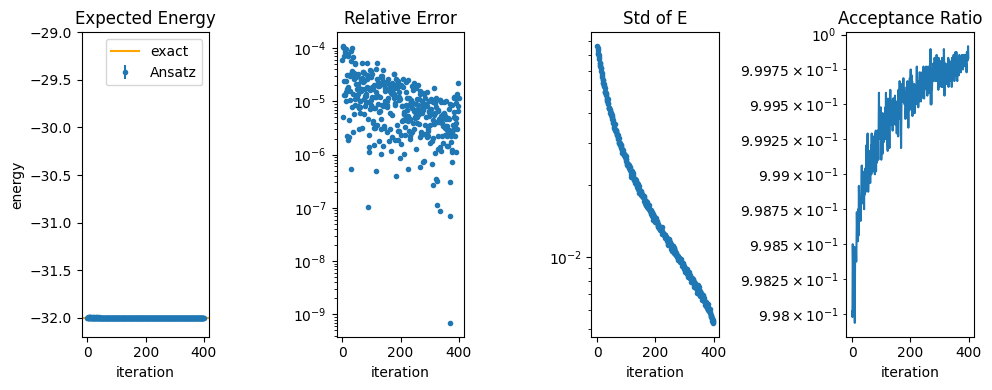

In [22]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 4, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
ax[0].set_title("Expected Energy")
ax[0].axhline(E_f, label = "exact", color = "orange")
ax[0].legend(loc = "upper right")
ax[0].set_ylim(E_f-0.2, E_f+3)
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("energy")

ax[1].scatter(i, jnp.abs(numpy_stats["E"]-E_f)/-E_f , label = "error", marker = ".")
ax[1].set_title("Relative Error")
ax[1].set_yscale("log")
# ax[1].set_xscale("log")
ax[1].set_xlabel("iteration")
# ax[1].set_xlim(i[-20], i[-1])

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")
ax[2].set_xlabel("iteration")

ax[3].plot(stats["ratio"])
# ax[3].set_ylim(0,1)
ax[3].set_title("Acceptance Ratio")
ax[3].set_xlabel("iteration")
ax[3].set_yscale("log")

f.tight_layout()

# n_param = sum(x.size for x in jax.tree_util.tree_leaves(param))

In [23]:
N = 30000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
H_loc = calc_H_loc(ansatz, param, samples).real
print("Acceptance Ratio:\t", ratio)
print("Expected Energy:\t\t", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Ground Truth:\t\t\t", E_f)
print("Energy Error:\t\t", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:\t", jnp.std(H_loc))

Acceptance Ratio:	 0.9998291666666668
Expected Energy:		 -31.999387378568173 +/- 3.052169165275468e-05
Ground Truth:			 -32.00000000000016
Energy Error:		 1.9144419749705834e-05
Std of Expected Energy:	 0.005286512067552199


In [24]:
psi = ansatz.calc_psi(param, all_states)

In [35]:
jnp.sum(all_states, axis = -1)

Array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

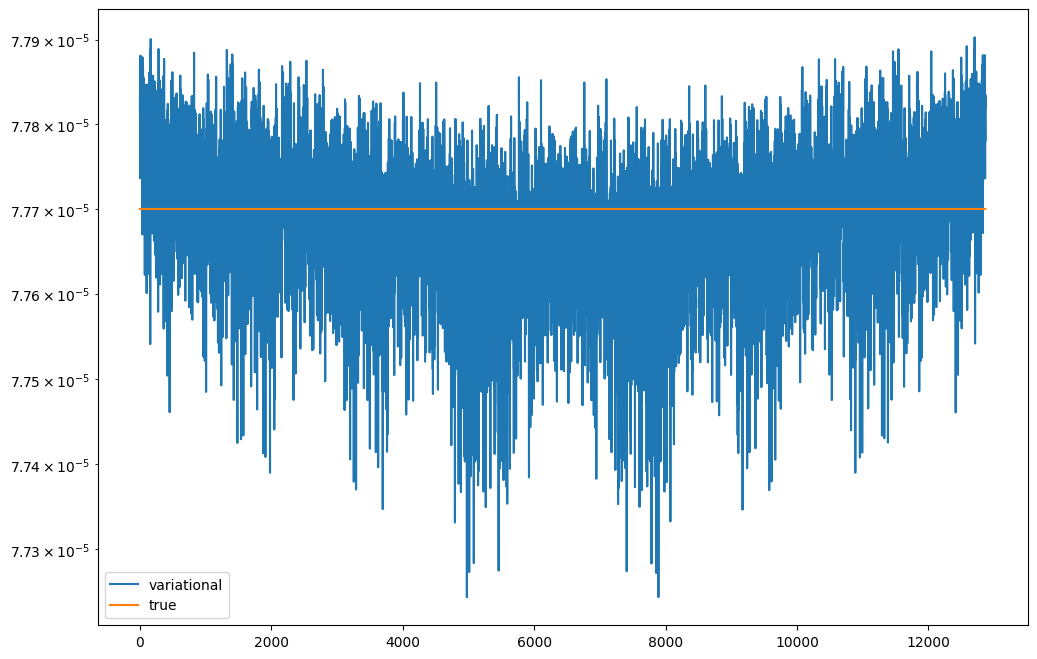

In [36]:
plt.figure(figsize=(12,8))
plt.plot(jnp.abs(psi)**2/jnp.sum(jnp.abs(psi)**2), label = "variational")
plt.plot(jnp.abs(psi_gs)**2/jnp.sum(jnp.abs(psi_gs)**2), label="true")

plt.yscale("log")
# plt.xlim(0,1000)
plt.legend()

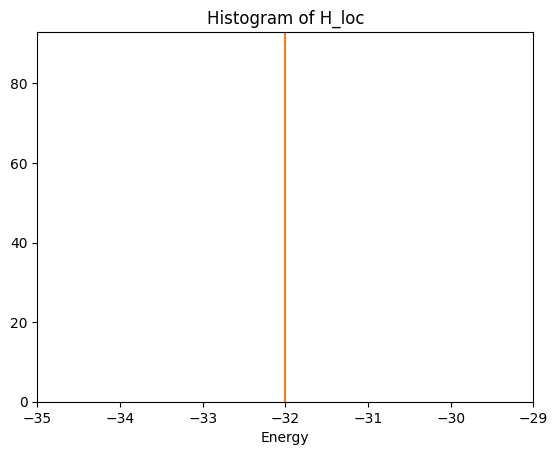

In [39]:
plt.hist(H_loc, bins=500, density=True)
plt.axvline(E_f, color = "C1")
# plt.ylim(0,20)
plt.title("Histogram of H_loc")
plt.xlabel("Energy")
plt.xlim(E_f - 3, E_f + 3)
pass

---